## Starter code

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import json

names = json.loads(open("../data/names.txt", "r").read())
names = names["payload"]["blob"]["rawLines"]
names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
print("Length of dataset: ", len(names))

Length of dataset:  32033


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(names))))
chtoi = {ch:i+1 for i, ch in enumerate(chars)}
chtoi["."] = 0
itoch = {i:ch for ch, i in chtoi.items()}
vocab_size = len(chtoi)
print("chtoi: ", chtoi)
print("itoch: ", itoch)
print("vocab_size: ", vocab_size)

chtoi:  {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
itoch:  {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocab_size:  27


In [5]:
import random

def build_dataset(data, mode="tr", context_len=3):
  """
  Builds the dataset from the given list of words.
  
  Args:
    data (list): list of words to use
    mode (str): mode of the dataset (default: "tr" for training)
    context_len (int): length of the context window (default: 3)
  """
  
  X, y = [], []
  
  for word in data:
    context = [0] * context_len
    for ch in word + ".":
      ix = chtoi[ch]
      X.append(context)
      y.append(ix)
      context = context[1:] + [ix]
  
  X = torch.tensor(X)
  y = torch.tensor(y)
  
  print(f"X{mode}.shape: {X.shape}, y{mode}.shape: {y.shape}")
  return X, y


random.shuffle(names)
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

Xtr, ytr = build_dataset(names[:n1])
Xval, yval = build_dataset(names[n1:n2], mode="val")
Xte, yte = build_dataset(names[n2:], mode="te")

Xtr.shape: torch.Size([182384, 3]), ytr.shape: torch.Size([182384])
Xval.shape: torch.Size([22883, 3]), yval.shape: torch.Size([22883])
Xte.shape: torch.Size([22879, 3]), yte.shape: torch.Size([22879])


In [6]:
def cmp(s, dt, t):
  """
  Utility function to compare manual and PyTorch gradients

  Args:
    s (str): name of the tensor
    dt (torch.Tensor): manual gradient
    t (torch.Tensor): PyTorch gradient
  """
  
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  max_diff = (dt - t.grad).abs().max().item()
  print(f"{s:15s} | exact: {str(ex):5s} | approx: {str(app):5s} | max_diff: {max_diff:.2f}")

In [7]:
import math

n_embd = 10         # dimensionality of character embeddings vector
n_hidden = 64       # number of neurons in the hidden layer
context_len = 3     # length of the context window
gain = 5.0 / 3.0    # gain for the Kaiming initialization

"""
Parameters are initialized in non-standard ways because initializing them with
all zeroes could mask an incorrect implementation of the backpropagation.

Using b1 despite batch normalization because it's easier to compare the gradients.
"""

C =  torch.randn(vocab_size, n_embd,             requires_grad=True)
# Layer 1
W1 = torch.randn(n_embd * context_len, n_hidden, requires_grad=True) * gain / math.sqrt(n_embd * context_len)
b1 = torch.randn(n_hidden,                       requires_grad=True) * 0.1
# Layer 2
W2 = torch.randn(n_hidden, vocab_size,           requires_grad=True) * 0.1
b2 = torch.randn(vocab_size,                     requires_grad=True) * 0.1
# BatchNorm params
gamma = torch.randn(1, n_hidden,                 requires_grad=True) * 0.1 + 1.0
beta =  torch.randn(1, n_hidden,                 requires_grad=True) * 0.1

params = [C, W1, b1, W2, b2, gamma, beta]
sum(p.nelement() for p in params)

4137

In [8]:
batch_size = 32

# construct a mini-batch
ix = torch.randint(0, len(Xtr), (batch_size,))
Xb, yb = Xtr[ix], ytr[ix]     # batch X, y

In [9]:
# manual implementation of forward pass
emb = C[Xb]                                                      # embedding characters into vectors
embcat = emb.view(emb.shape[0], -1)                              # concatenate embeddings

# Linear layer 1
hprebn = embcat @ W1 + b1                                        # pre-batchnorm hidden layer

In [10]:
# PyTorch implementation of batch normalization
hpreact_fast = gamma * (hprebn - hprebn.mean(dim=0, keepdim=True)) / torch.sqrt(hprebn.var(dim=0, keepdim=True, unbiased=True) + 1e-5) + beta

In [11]:
# explicit implementation of batch normalization
bnmeani = hprebn.mean(dim=0, keepdim=True)
bndiff = hprebn - bnmeani
bndiffsq = bndiff ** 2
bnvar = bndiffsq.sum(dim=0, keepdim=True) / (batch_size - 1)     # Bessel's correction (N-1)
bnvar_inv = (bnvar + 1e-5) ** -0.5                               # equivalent to 1.0 / torch.sqrt(bnvar + 1e-5)
bnraw = bndiff * bnvar_inv
hpreact = gamma * bnraw + beta
print("max diff: ", round((hpreact - hpreact_fast).abs().max().item(), 4))

max diff:  0.0


In [12]:
# non-linearity
h = torch.tanh(hpreact)

# Linear layer 2
logits = h @ W2 + b2                                             # output layer

In [13]:
# PyTorch implementation of cross-entropy loss
loss_fast = F.cross_entropy(logits, yb)
loss_fast

tensor(3.4687, grad_fn=<NllLossBackward0>)

In [14]:
# explicit implementation of cross-entropy loss
logits_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logits_maxes                              # subtract max for numerical stability
counts = norm_logits.exp()                                       # transform logits into positive values
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum ** -1                                # (1.0 / counts_sum) cannot get bit-exact backpropagation
probs = counts * counts_sum_inv                                  # transform normalized counts into probabilities
log_probs = probs.log()
loss = -log_probs[range(batch_size), yb].mean()
print(round(loss.item(), 4), "max diff: ", round(loss_fast.item() - loss.item(), 4))

3.4687 max diff:  -0.0


In [15]:
# Pytorch gradient computation
training_tensors = [log_probs, probs, counts_sum_inv, counts_sum, counts, norm_logits, logits_maxes, logits, h, W2, b2, hpreact, gamma, beta, bnraw, bnvar_inv, bnvar, bndiffsq, bndiff, bnmeani, hprebn, embcat, emb, W1, b1]

for t in training_tensors:
  t.retain_grad()

for p in params:
  p.grad = None

loss.backward()
loss

tensor(3.4687, grad_fn=<NegBackward0>)

## 1. Atomic compute graph backpropagation

Implement backpropagation manually for the entire forward pass compute graph, using atomic operations as building blocks.

### Step: Explicit implementation of cross entropy loss

In [16]:
"""
interpretation: how loss changes with respect to each of log_probs

derivation of log_probs in relation to loss: loss = -log_probs[range(batch_size), yb].mean()
loss = - (a + b + c) / n
loss = -a/n + -b/n + -c/n
dloss_da = -1/n
dloss_db = -1/n
dloss_dc = -1/n
"""
dloss_dlogprobs = torch.zeros_like(log_probs)
dloss_dlogprobs[range(batch_size), yb] = -1.0 / batch_size
cmp("dloss_dlogprobs", dloss_dlogprobs, log_probs)

dloss_dlogprobs | exact: True  | approx: True  | max_diff: 0.00


In [17]:
"""
interpretation: how loss changes with respect to each of probs
note: intuitively, a high probability character will be simply passed through the chain rule, while a low probability will be boosted to generate a high local gradient.

derivation of probs in relation to log_probs: log_probs = probs.log()
log_probs = log(a), log(b), log(c)
dlogprobs_da = 1/a
dlogprobs_db = 1/b
dlogprobs_dc = 1/c

derivation of probs in relation to loss: dlogprobs_dn * chain_rule
"""
dloss_dprobs = 1.0 / probs * dloss_dlogprobs
cmp("dloss_dprobs", dloss_dprobs, probs)

dloss_dprobs    | exact: True  | approx: True  | max_diff: 0.00


In [18]:
"""
interpretation: how loss changes with respect to each of counts_sum_inv

derivation of counts_sum_inv in relation to probs: probs = counts * counts_sum_inv
probs = a * b
dprobs_da = b
dprobs_db = a

counts.shape: (batch_size, vocab_size)
counts_sum_inv.shape: (batch_size, 1)

matrix broadcasting with tensors:
a[3,2] * b[3,1] ---> c[3,2]
a11 * b1, a12 * b1
a21 * b2, a22 * b2
a31 * b3, a32 * b3

derivation of counts_sum_inv in relation to loss: SUM(dprobs_dn * chain_rule) backpropagating through matrix broadcasting
"""
dloss_dcountssuminv = (counts * dloss_dprobs).sum(1, keepdim=True)
cmp("dloss_dcountssuminv", dloss_dcountssuminv, counts_sum_inv)

dloss_dcountssuminv | exact: True  | approx: True  | max_diff: 0.00


In [19]:
"""
interpretation: how loss changes with respect to each of counts_sum

derivation of counts_sum in relation to counts_sum_inv: counts_sum_inv = counts_sum ** -1
counts_sum_inv = a^-1
dcountssum_da = - a^-2

derivation of counts_sum in relation to loss: dcountssum_dn * chain_rule
"""
dloss_dcountssum = -counts_sum ** -2 * dloss_dcountssuminv
cmp("dloss_dcountssum", dloss_dcountssum, counts_sum)

dloss_dcountssum | exact: True  | approx: True  | max_diff: 0.00


In [20]:
"""
interpretation: how loss changes with respect to each of counts
note: both probs and counts_sum depend on counts, so we need to backpropagate through both branches

(1st branch) derivation of counts in relation to probs: probs = counts * counts_sum_inv
probs = a * b
dprobs_da = b
dprobs_db = a

(2nd branch) derivation of counts in relation to counts_sum: counts_sum = counts.sum(1, keepdim=True)
counts_sum = a + b + c
dcountssum_da = 1
dcountssum_db = 1
dcountssum_dc = 1

counts.shape: (batch_size, vocab_size)
counts_sum.shape: (batch_size, 1)

matrix broadcasting with tensors:
sum(a[3,2]) ---> b[3,1]
a11 + a12 ---> b1
a21 + a22 ---> b2
a31 + a32 ---> b3

derivation of counts in relation to loss: dprobs_dn * chain_rule + dcountssum_dn * chain_rule
"""
dloss_dcounts = counts_sum_inv * dloss_dprobs + torch.ones_like(counts) * dloss_dcountssum
cmp("dloss_dcounts", dloss_dcounts, counts)

dloss_dcounts   | exact: True  | approx: True  | max_diff: 0.00


In [21]:
"""
interpretation: how loss changes with respect to each of norm_logits

derivation of norm_logits in relation to counts: counts = norm_logits.exp()
counts = e^a
dcounts_da = e^a

derivation of norm_logits in relation to loss: dcounts_dn * chain_rule
"""
dloss_dnormlogits = counts * dloss_dcounts
cmp("dloss_dnormlogits", dloss_dnormlogits, norm_logits)

dloss_dnormlogits | exact: True  | approx: True  | max_diff: 0.00


In [22]:
"""
interpretation: how loss changes with respect to each of logits_maxes
note: logits_maxes are calculated only for numerical stability of softmax function and do not affect the loss. Therefore, the gradient is zero (or close to it, due to floating point precision).

derivation of logits_maxes in relation to norm_logits: norm_logits = logits - logits_maxes
norm_logits = a + -b
dnormlogits_da = 1
dnormlogits_db = -1

counts.shape: (batch_size, vocab_size)
counts_sum_inv.shape: (batch_size, 1)

matrix broadcasting with tensors:
a[3,2] - b[3,1] ---> c[3,2]
a11 - b1, a12 - b1
a21 - b2, a22 - b2
a31 - b3, a32 - b3

derivation of logits_maxes in relation to loss: SUM(dnormlogits_dn * chain_rule) backpropagating through matrix broadcasting
"""
dloss_dlogitsmaxes = -dloss_dnormlogits.sum(1, keepdim=True)
cmp("dloss_dlogitsmaxes", dloss_dlogitsmaxes, logits_maxes)

dloss_dlogitsmaxes | exact: True  | approx: True  | max_diff: 0.00


In [23]:
"""
interpretation: how loss changes with respect to each of logits
note: both norm_logits and logits_maxes depend on logits, so we need to backpropagate through both branches

(1st branch) derivation of logits in relation to norm_logits: check dloss_dlogitsmaxes

(2nd branch) derivation of logits in relation to logits_maxes: logits_maxes = logits.max(1, keepdim=True).values
logits_maxes = a
dlogitsmaxes_da = 1

derivation of logits in relation to loss: dnormlogits_dn * chain_rule + dlogitsmaxes_dn * chain_rule
"""
dloss_dlogits = dloss_dnormlogits.clone() + F.one_hot(logits.max(dim=1).indices, num_classes=logits.shape[1]) * dloss_dlogitsmaxes
cmp("dloss_dlogits", dloss_dlogits, logits)

dloss_dlogits   | exact: True  | approx: True  | max_diff: 0.00


Text(0.5, 1.0, 'One-hot encoding of the maximum logits')

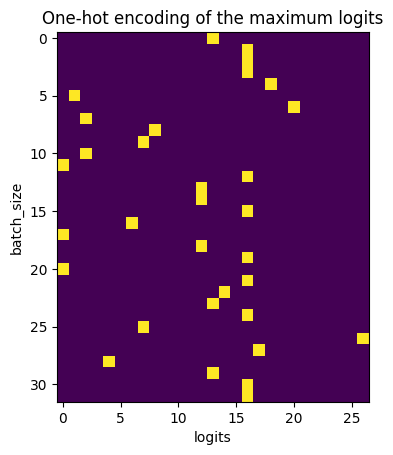

In [24]:
plt.imshow(F.one_hot(logits.max(dim=1).indices, num_classes=logits.shape[1]))
plt.xlabel("logits")
plt.ylabel("batch_size")
plt.title("One-hot encoding of the maximum logits")

### Step: Linear layer 2

In [25]:
"""
interpretation: how loss changes with respect to each element of the linear layer: logits = h @ W2 + b2

derivation of h in relation to logits: dlogits/dh = W2.T
derivation of W2 in relation to logits: dlogits/dW2 = h.T
derivation of b2 in relation to logits: dlogits/db2 = 1

h.shape: (batch_size, n_hidden)
W2.shape: (n_hidden, vocab_size)
b2.shape: (vocab_size,)

matrix broadcasting with tensors:
d[2,2] ---> a[2,2] @ b[2,2] + c[2]
d11 = a11 * b11 + a12 * b21 + c1
d12 = a11 * b12 + a12 * b22 + c2
d21 = a21 * b11 + a22 * b21 + c1
d22 = a21 * b12 + a22 * b22 + c2

derivation of x in relation to a: dx/da[i,j] = dx/dd[i,j] @ b[i,j].T
dx/da11 = dx/dd11 * b11 + dx/dd12 * b12
dx/da12 = dx/dd11 * b21 + dx/dd12 * b22
dx/da21 = dx/dd21 * b11 + dx/dd22 * b12
dx/da22 = dx/dd21 * b21 + dx/dd22 * b22

derivation of x in relation to b: dx/db[i, j] = a[i, j].T @ dx/dd[i, j]

derivation of x in relation to c: dx/dc[i] = dx/dd[i].sum(dim=0)
dx/dc1 = dx/dd11 * 1 + dx/dd21 * 1
dx/dc2 = dx/dd12 * 1 + dx/dd22 * 1

derivation of h in relation to loss: chain rule @ W2.T
derivation of W2 in relation to loss: h.T @ chain rule
derivation of b2 in relation to loss: SUM(chain rule) @ 1
"""
dloss_dh = dloss_dlogits @ W2.T
dloss_dW2 = h.T @ dloss_dlogits
dloss_db2 = dloss_dlogits.sum(dim=0)
cmp("dloss_dh", dloss_dh, h)
cmp("dloss_dW2", dloss_dW2, W2)
cmp("dloss_db2", dloss_db2, b2)

dloss_dh        | exact: True  | approx: True  | max_diff: 0.00
dloss_dW2       | exact: True  | approx: True  | max_diff: 0.00
dloss_db2       | exact: True  | approx: True  | max_diff: 0.00


### Step: Non-linearity

In [26]:
"""
interpretation: how loss changes with respect to each output of the first layer before activation (hpreact)

derivation of hpreact in relation to h: h = torch.tanh(hpreact)
h = tanh(a)
dh_da = 1 - h^2

derivation of hpreact in relation to loss: dh_dn * chain_rule
"""
dloss_dhpreact = (1.0 - h ** 2) * dloss_dh
cmp("dloss_dhpreact", dloss_dhpreact, hpreact)

dloss_dhpreact  | exact: True  | approx: True  | max_diff: 0.00


### Step: Batch Normalization

In [27]:
"""
interpretation: how loss changes with respect to each element of the batch normalization output: hpreact = gamma * bnraw + beta

derivation of gamma in relation to hpreact:
hpreact = a * b + c
dpreact_da = b
dpreact_db = a

derivation of bnraw in relation to hpreact: see above

derivation of beta in relation to hpreact:
dpreact_dc = 1

gamma.shape: (1, n_hidden)
bnraw.shape: (batch_size, n_hidden)
beta.shape: (1, n_hidden)

derivation of gamma in relation to loss: SUM(dpreact_dn * chain_rule) backpropagating through matrix broadcasting
derivation of bnraw in relation to loss: dpreact_dn * chain_rule
derivation of beta in relation to loss: SUM(dpreact_dn * chain_rule) backpropagating through matrix broadcasting
"""
dloss_dgamma = (bnraw * dloss_dhpreact).sum(dim=0, keepdim=True)
dloss_dbnraw = (gamma * dloss_dhpreact)
dloss_dbeta = dloss_dhpreact.sum(dim=0, keepdim=True)
cmp("dloss_dgamma", dloss_dgamma, gamma)
cmp("dloss_dbnraw", dloss_dbnraw, bnraw)
cmp("dloss_dbeta", dloss_dbeta, beta)

dloss_dgamma    | exact: True  | approx: True  | max_diff: 0.00
dloss_dbnraw    | exact: True  | approx: True  | max_diff: 0.00
dloss_dbeta     | exact: True  | approx: True  | max_diff: 0.00


In [28]:
"""
interpretation: how loss changes with respect to each of bnvar_inv

derivation of bnvar_inv in relation to bnraw: bnraw = bndiff * bnvar_inv
bnraw = a * b
dbnraw_da = b
dbnraw_db = a

derivation of bnvar_inv in relation to loss: SUM(dbnraw_dn * chain_rule) backpropagating through matrix broadcasting
"""
dloss_dbnvarinv = (bndiff * dloss_dbnraw).sum(dim=0, keepdim=True)
cmp("dloss_dbnvarinv", dloss_dbnvarinv, bnvar_inv)

dloss_dbnvarinv | exact: True  | approx: True  | max_diff: 0.00


In [29]:
"""
interpretation: how loss changes with respect to each of bnvar

derivation of bnvar in relation to bnvar_inv: bnvar_inv = (bnvar + 1e-5)^-0.5
bnvar_inv = a^b
dbnvarinv_da = b * a^(b-1)

derivation of bnvar in relation to loss: dbnvarinv_dn * chain_rule
"""
dloss_dbnvar = -0.5 * (bnvar + 1e-5) ** (-0.5 - 1) * dloss_dbnvarinv
cmp("dloss_dbnvar", dloss_dbnvar, bnvar)

dloss_dbnvar    | exact: True  | approx: True  | max_diff: 0.00


In [30]:
"""
interpretation: how loss changes with respect to each of bndiffsq

derivation of bndiffsq in relation to bnvar: bnvar = bndiffsq.sum(dim=0, keepdim=True) / (batch_size - 1)
bnvar = (a + b + c) / (n - 1)
dbnvar_dn = 1 / (n - 1)

derivation of bndiffsq in relation to loss: dbnvar_dn * chain_rule
"""
dloss_dbndiffsq = torch.ones_like(bndiffsq) * dloss_dbnvar / (batch_size - 1)
cmp("dloss_dbndiffsq", dloss_dbndiffsq, bndiffsq)

dloss_dbndiffsq | exact: True  | approx: True  | max_diff: 0.00


In [31]:
"""
interpretation: how loss changes with respect to each of bndiff
note: both bnraw and bndiffsq depend on counts, so we need to backpropagate through both branches

(1st branch) derivation of bndiff in relation to bnraw: bnraw = bndiff * bnvar_inv
bnraw = a * b
dbnraw_da = b
dbnraw_db = a

(2nd branch) derivation of bndiff in relation to bndiffsq: bndiffsq = bndiff^2
bndiffsq = a^2
dbndiffsq_da = 2a

derivation of bndiff in relation to loss: dbnraw_dn * chain_rule + dbndiffsq_dn * chain_rule
"""
dloss_dbndiff = bnvar_inv * dloss_dbnraw + 2 * bndiff * dloss_dbndiffsq
cmp("dloss_dbndiff", dloss_dbndiff, bndiff)

dloss_dbndiff   | exact: True  | approx: True  | max_diff: 0.00


In [32]:
"""
interpretation: how loss changes with respect to each of bnmeani

derivation of bnmeani in relation to bndiff: bndiff = hprebn - bnmeani
bndiff = a + -b
dbndiff_da = 1
dbndiff_db = -1

derivation of bnmeani in relation to loss: SUM(-1.0 * chain_rule) backpropagating through matrix broadcasting
"""
dloss_dbnmeani = -dloss_dbndiff.sum(dim=0, keepdim=True)
cmp("dloss_dbnmeani", dloss_dbnmeani, bnmeani)

dloss_dbnmeani  | exact: True  | approx: True  | max_diff: 0.00


In [33]:
"""
interpretation: how loss changes with respect to each of hprebn
note: both bndiff and bnmeani depend on hprebn, so we need to backpropagate through both branches

(1st branch) derivation of hprebn in relation to bndiff: bndiff = hprebn - bnmeani
bndiff = a + -b
dbndiff_da = 1
dbndiff_db = -1

(2nd branch) derivation of hprebn in relation to bnmeani: bnmeani = hprebn.mean(dim=0, keepdim=True)
bnmeani = (a + b) / 2
dbnmeani_da = 1 / 2

derivation of hprebn in relation to loss: 1.0 * chain_rule + dbnmeani_dn * chain_rule
"""
dloss_dhprebn = dloss_dbndiff.clone() + torch.ones_like(hprebn) / hprebn.shape[0] * dloss_dbnmeani
cmp("dloss_dhprebn", dloss_dhprebn, hprebn)

dloss_dhprebn   | exact: True  | approx: True  | max_diff: 0.00


### Step: Linear layer 1

In [34]:
"""
interpretation: how loss changes with respect to each element of the linear layer: hprebn = embcat @ W1 + b1    

derivation of embcat in relation to hprebn: dhprebn/dembcat = W1.T
derivation of W1 in relation to hprebn: dhprebn/dW1 = embcat.T
derivation of b1 in relation to hprebn: dhprebn/db1 = 1

derivation of embcat in relation to loss: chain rule @ W1.T
derivation of W1 in relation to loss: embcat.T @ chain rule
derivation of b1 in relation to loss: SUM(chain rule) @ 1
"""
dloss_dembcat = dloss_dhprebn @ W1.T
dloss_dW1 = embcat.T @ dloss_dhprebn
dloss_db1 = dloss_dhprebn.sum(dim=0)
cmp("dloss_dembcat", dloss_dembcat, embcat)
cmp("dloss_dW1", dloss_dW1, W1)
cmp("dloss_db1", dloss_db1, b1)

dloss_dembcat   | exact: True  | approx: True  | max_diff: 0.00
dloss_dW1       | exact: True  | approx: True  | max_diff: 0.00
dloss_db1       | exact: True  | approx: True  | max_diff: 0.00


### Step: Setup the forward pass

In [35]:
"""
interpretation: how loss changes with respect to each of emb

derivation of emb in relation to loss: embcat = emb.view(emb.shape[0], -1)    
note: embcat is a reshaped version of emb and its derivative is the undo of the reshape
"""
dloss_demb = dloss_dembcat.view(emb.shape)
cmp("dloss_demb", dloss_demb, emb)

dloss_demb      | exact: True  | approx: True  | max_diff: 0.00


In [36]:
"""
interpretation: how loss changes with respect to each of C

derivation of C in relation to emb: emb = C[Xb]     
note: emb is the result of an indexing operation and its derivative is the undo of the indexing

emb.shape: (batch_size, context_len, n_embd)
C.shape: (vocab_size, n_embd)
Xb.shape: (batch_size, context_len)
"""
dloss_dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k, j]
    dloss_dC[ix] += dloss_demb[k, j]
cmp("dloss_dC", dloss_dC, C)

dloss_dC        | exact: True  | approx: True  | max_diff: 0.00


## 2. Cross entropy backpropagation in one go

The atomic computation performed above is inefficient. For example, the cross entropy loss could be calculated as a single operation that can be backpropagated in one go.

<img src="../assets/nn-strut.jpg" width="700"/>

Considering the structure above, to backward propagate the loss all the way to logits in one step for a single individual example:

$\text{loss} = -\log P(y)$, where $P$ is the softmax vector output, and $y$ is the true label position in the vector.

$P(i) = \frac{e^{l_i}}{\sum_{j} e^{l_j}}$, where $l$ is the logits vector, and $i$ is the position in the vector.

The derivative of the loss with respect to the i-th logit is: $\frac{\partial \text{loss}}{\partial l_i} = \frac{\partial \text{loss}}{\partial l_i}[-\log \frac{e^{l_i}}{\sum_{j} e^{l_j}}]$. Deriving this expression, we get: $\frac{\partial \text{loss}}{\partial l_i} = P(i) - 1(y=i)$, where $1(y=i)$ is the indicator function that is 1 when $y=i$, and 0 otherwise.

In [37]:
# The match is not exact due to the floating point precision
dloss_dlogits_fast = F.softmax(logits, dim=1)
dloss_dlogits_fast[range(batch_size), yb] -= 1.0
dloss_dlogits_fast /= batch_size
cmp("dloss_dlogits_fast", dloss_dlogits_fast, logits)

dloss_dlogits_fast | exact: False | approx: True  | max_diff: 0.00


First row of probabilities:  [0.05460495 0.01869192 0.06089635 0.01185056 0.01790318 0.04536892
 0.02940609 0.04925381 0.03800049 0.02144133 0.01881717 0.01339234
 0.04546446 0.09663055 0.02534464 0.03392309 0.03320727 0.03450454
 0.07901236 0.01965421 0.05352899 0.03588085 0.02504592 0.03852617
 0.02083166 0.03107048 0.04774765]
First row of dloss_dlogits:  [ 0.05460495  0.01869192  0.06089636  0.01185056  0.01790318  0.04536892
  0.02940609  0.04925381  0.03800049  0.02144133  0.01881717  0.01339234
  0.04546446  0.09663058 -0.9746554   0.03392309  0.03320728  0.03450454
  0.07901236  0.01965421  0.053529    0.03588085  0.02504592  0.03852617
  0.02083166  0.03107048  0.04774765]
Sum of first row of dloss_dlogits:  -6.984919309616089e-10


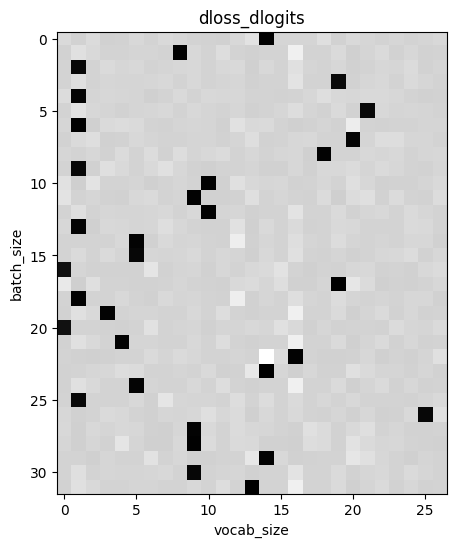

In [38]:
"""
Interpretation: the black squares are the positions of the correct character in each row, where 1.0 was subtracted from the softmax output.
                Consider the gradients at each cell like a `force`, pulling down on the probabilities of the incorrect characters and pushing up on the probability of the correct character. The amount of force (pull and push) is exactly equalized across the row, so that the sum of the forces is zero (ie. repulsion and attraction are equal). Think of the neural net as a massive pulley system, where the forces are balanced across the row, so that the net doesn't move in any direction. This is the essence of the backpropagation algorithm.

                For example, if the probability came out exactly correct, the vector would have zeroes everywhere, except for a one at the correct position, resulting in dloss_dlogits being a vector of only zeroes (no pull or push). On the other hand, a very confidently misprediction would be pulled down very heavily and the correct answer will be pushed up by the same amount, while the remaining characters will not be influenced too much.
"""
print("First row of probabilities: ", F.softmax(logits, dim=1)[0].detach().numpy())
print("First row of dloss_dlogits: ", (dloss_dlogits[0] * batch_size).detach().numpy())
print("Sum of first row of dloss_dlogits: ", dloss_dlogits[0].sum().item())

plt.figure(figsize=(6, 6))
plt.imshow(dloss_dlogits_fast.detach(), cmap="gray")
plt.title("dloss_dlogits")
plt.xlabel("vocab_size")
plt.ylabel("batch_size");

## 3. Batch normalization in one go

In order to calculate the $\frac{\partial \text{loss}}{\partial x_i}$ for the batch normalization layer in a single step, consider the algorithm implementation below, from the Batch Norm paper:

<img src="../assets/batch-norm-algo.jpg" width="400"/>

In this exercise, the algorithm was implemented as shown above, except that it used Bessel's correction for the variance calculation.

After all the required derivations (not trivial), the final expression for the derivative of the loss with respect to the input of the batch normalization layer is:

$\frac{\partial \text{loss}}{\partial x_i} = \frac{\gamma(\sigma^2 + \epsilon)^{-1/2}}{m}[m \frac{\partial \text{loss}}{\partial y_i} - \sum_{j} \frac{\partial \text{loss}}{\partial y_j} - \frac{m}{m-1} \hat{x}_i \sum_{j} \frac{\partial \text{loss}}{\partial y_i} \hat{x}_j]$, where $j$ is the local iterator over the batch, representing the index of the elements in the batch.

In [39]:
# The match is not exact due to the floating point precision
dloss_dhprebn_fast = gamma * bnvar_inv / batch_size * (batch_size * dloss_dhpreact - dloss_dhpreact.sum(dim=0) \
                                                       - batch_size / (batch_size - 1) * bnraw * (dloss_dhpreact * bnraw).sum(dim=0))
cmp("dloss_dhprebn_fast", dloss_dhprebn_fast, hprebn)

dloss_dhprebn_fast | exact: False | approx: True  | max_diff: 0.00


## 4. Putting it all together

Train the neural network with the self implemented backpropagation algorithm.

In [40]:
n_embd = 10         # dimensionality of character embeddings vector
n_hidden = 200      # number of neurons in the hidden layer

C =  torch.randn(vocab_size, n_embd)
# Layer 1
W1 = torch.randn(n_embd * context_len, n_hidden) * gain / math.sqrt(n_embd * context_len)
b1 = torch.randn(n_hidden) * 0.1
# Layer 2
W2 = torch.randn(n_hidden, vocab_size) * 0.1
b2 = torch.randn(vocab_size) * 0.1
# BatchNorm params
gamma = torch.randn(1, n_hidden) * 0.1 + 1.0
beta =  torch.randn(1, n_hidden) * 0.1

params = [C, W1, b1, W2, b2, gamma, beta]
for p in params:
  p.requires_grad = False

# optimization hyperparameters
max_epochs = 200_000
batch_size = 32
lossi = []

In [41]:
with torch.no_grad():
  for epoch in range(max_epochs):
    # construct a mini-batch
    ix = torch.randint(0, len(Xtr), (batch_size,))
    Xb, yb = Xtr[ix], ytr[ix]            # batch X, y

    # forward pass
    emb = C[Xb]                          # embedding characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate embeddings

    # Linear layer 1
    hprebn = embcat @ W1 + b1            # pre-batchnorm hidden layer

    # Batch normalization
    bnmean = hprebn.mean(dim=0, keepdim=True)
    bnvar = hprebn.var(dim=0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5) ** -0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = gamma * bnraw + beta

    # non-linearity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2                 # output layer
    loss = F.cross_entropy(logits, yb)   # cross-entropy loss

    # backward pass
    for p in params:
      p.grad = None

    # manual backpropagation
    dloss_dlogits = F.softmax(logits, dim=1)
    dloss_dlogits[range(batch_size), yb] -= 1.0
    dloss_dlogits /= batch_size

    dloss_dh = dloss_dlogits @ W2.T
    dloss_dW2 = h.T @ dloss_dlogits
    dloss_db2 = dloss_dlogits.sum(dim=0)

    dloss_dhpreact = (1.0 - h ** 2) * dloss_dh

    dloss_dgamma = (bnraw * dloss_dhpreact).sum(dim=0, keepdim=True)
    dloss_dbeta = dloss_dhpreact.sum(dim=0, keepdim=True)
    dloss_dhprebn = gamma * bnvar_inv / batch_size * (batch_size * dloss_dhpreact - dloss_dhpreact.sum(dim=0) \
                                                      - batch_size / (batch_size - 1) * bnraw * (dloss_dhpreact * bnraw).sum(dim=0))
    
    dloss_dembcat = dloss_dhprebn @ W1.T
    dloss_dW1 = embcat.T @ dloss_dhprebn
    dloss_db1 = dloss_dhprebn.sum(dim=0)

    dloss_demb = dloss_dembcat.view(emb.shape)
    dloss_dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dloss_dC[ix] += dloss_demb[k, j]

    # update the parameters
    grads = [dloss_dC, dloss_dW1, dloss_db1, dloss_dW2, dloss_db2, dloss_dgamma, dloss_dbeta]
    lr = 0.1 if epoch < 100_000 else 0.01 
    for p, grad in zip(params, grads):
      p.data += -lr * grad

    # track stats
    if epoch % 25_000 == 0:
      print(f"Epoch {epoch:6d} / {max_epochs}: loss = {loss.item():.4f}")
    lossi.append(loss.item())

Epoch      0 / 200000: loss = 3.5745
Epoch  25000 / 200000: loss = 1.9827
Epoch  50000 / 200000: loss = 2.0217
Epoch  75000 / 200000: loss = 2.1881
Epoch 100000 / 200000: loss = 2.2718
Epoch 125000 / 200000: loss = 2.5477
Epoch 150000 / 200000: loss = 1.8672
Epoch 175000 / 200000: loss = 2.0027


In [42]:
# calibrate batch normalization parameters
with torch.no_grad():
  # pass the entire dataset through the network
  emb = C[Xtr]                          # embedding characters into vectors
  embcat = emb.view(emb.shape[0], -1)   # concatenate embeddings
  hprebn = embcat @ W1 + b1             # pre-batchnorm hidden layer
  # measure the mean and variance of the hidden layer
  bnmean = hprebn.mean(dim=0, keepdim=True)
  bnvar = hprebn.var(dim=0, keepdim=True, unbiased=True)

In [43]:
# evaluate train and validation loss
@torch.no_grad()
def split_loss(split):
  X, y = {
    "tr": (Xtr, ytr),
    "val": (Xval, yval),
    "te": (Xte, yte)
  }[split]
  emb = C[X]                         
  embcat = emb.view(emb.shape[0], -1)
  hprebn = embcat @ W1 + b1          
  hpreact = gamma * (hprebn - bnmean) / torch.sqrt(bnvar + 1e-5) + beta
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(f"loss_{split}: {loss.item():.4f}")

split_loss("tr")
split_loss("val")

loss_tr: 2.0711
loss_val: 2.1296


# Sources

1. [Ground truth - Building makemore Part 4: Becoming a Backprop Ninja, By Andrej Karpathy](https://www.youtube.com/watch?v=q8SA3rM6ckI&t=6s)
2. [Yes, you should understand backprop, By Andrej Karpathy](https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b)
3. [Bessel's Correction](https://math.oxford.emory.edu/site/math117/besselCorrection/)
4. [Reducing the Dimensionality of Data with Neural Networks, By G. Hinton](https://www.cs.toronto.edu/~hinton/absps/science.pdf)
5. Karpathy, Andrej; Li, Fei-Fei. Deep Fragment Embeddings for Bidirectional Image Sentence Mapping, 2014. URL: https://arxiv.org/pdf/1406.5679.pdf